In [1]:
import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rich import print, inspect, traceback, pretty
import scipy.interpolate as spi

from chaotic_carbon_networks.preprocessing import concat_data
from chaotic_carbon_networks.adjencency_matrix import calc_adjacency_matrix, calc_link_length, calc_similarity_matrix_v4
from chaotic_carbon_networks.utils import mask_oceans, plot_world
from chaotic_carbon_networks.population_masking import mask_population
from chaotic_carbon_networks.anomaly_correction import anomaly_correction_week, anomaly_correction_month, anomaly_correction_spatial
from chaotic_carbon_networks.measures import calc_degrees, calc_avg_link_length

sns.set_theme(context='paper', style="whitegrid", palette="Set2", font_scale=1.5, rc={'figure.figsize':(9,6)})
pretty.install()
traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7fc35ea39cd0>>

/tmp/ipykernel_30407/3595663554.py:17: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  co2 = co2.groupby("time").apply(interpolate_2d)


<xarray.DataArray (time: 203, lat: 90, lon: 180)> Size: 26MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2003-01-16T12:00:00 ... 2019-12-16T12:...
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
Attributes:
    standard_name:  dry_atmosphere_mole_fraction_of_carbon_dioxide
    long_name:      column-average dry-air mole fraction of atmospheric carbo...
    units:          1
    cell_methods:   time: mean
    fill_value:     1e+20
    comment:        Satellite retrieved column-average dry-air mole fraction ...

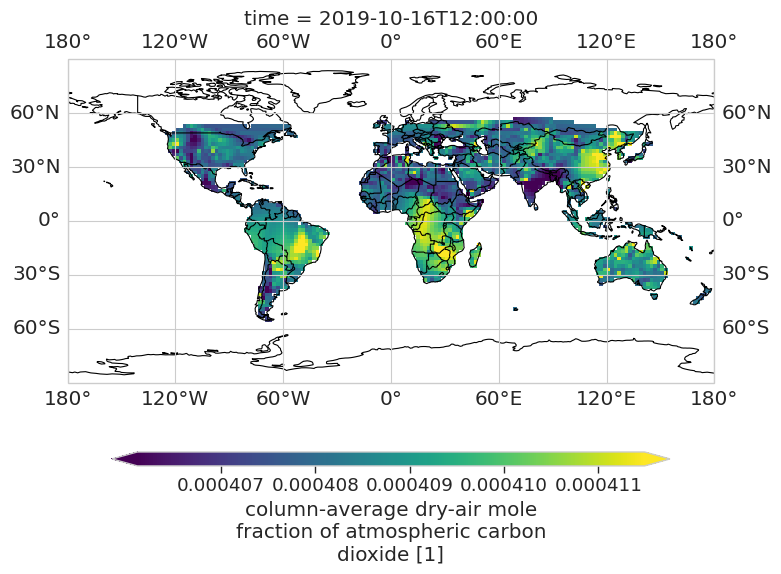

In [2]:
co2 = xr.open_dataset("../data/xco2_c3s_l3_v42_200301_201912_2x2.nc")["xco2"]
def interpolate_2d(da):
    # Create 2D coordinates grid
    X, Y = np.meshgrid(da["lon"], da["lat"])
    # Create mask for valid values
    mask = np.isfinite(da.values)
    # Interpolate over the grid
    Z = spi.griddata((X[mask], Y[mask]), da.values[mask], (X, Y), method="linear")
    Z = xr.DataArray(Z, coords=da.coords, dims=da.dims)
    Z.attrs = da.attrs
    return Z


# Interpolate missing data
co2 = co2.dropna(dim="time", how="all")
attrs = co2.attrs
co2 = co2.groupby("time").apply(interpolate_2d)
co2.attrs = attrs

# Masking
co2 = mask_oceans(co2)

# Interpolate missing data
# co2 = co2.interpolate_na(dim="time", method="linear")

plot_world(co2.isel(time=200))
co2

In [3]:
co2 = anomaly_correction_month(co2)

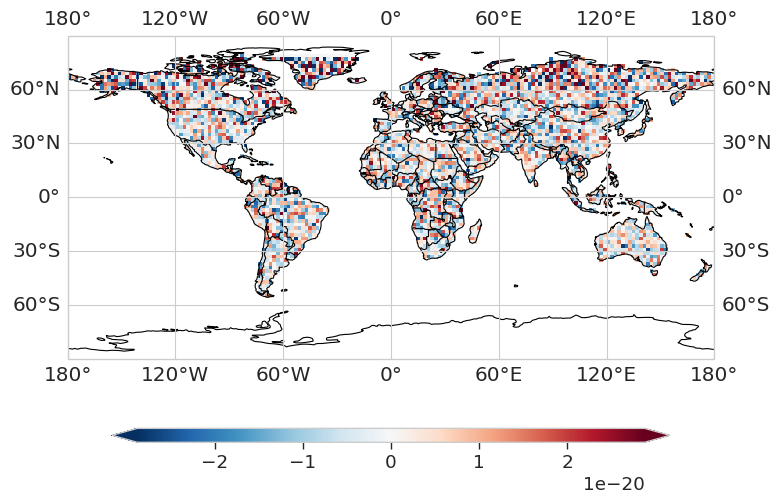

In [4]:
plot_world(co2.mean(dim="time"))

/home/tobias/.cache/pypoetry/virtualenvs/chaotic-carbon-networks-ujXUhOMb-py3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


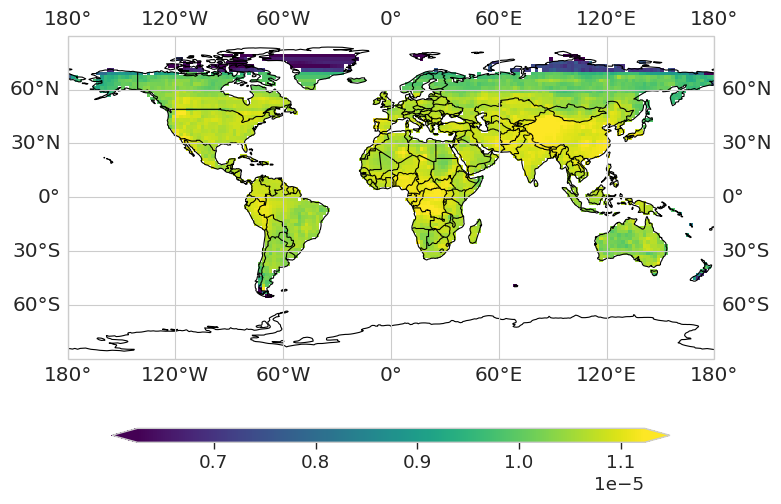

In [5]:
plot_world(co2.std(dim="time"))

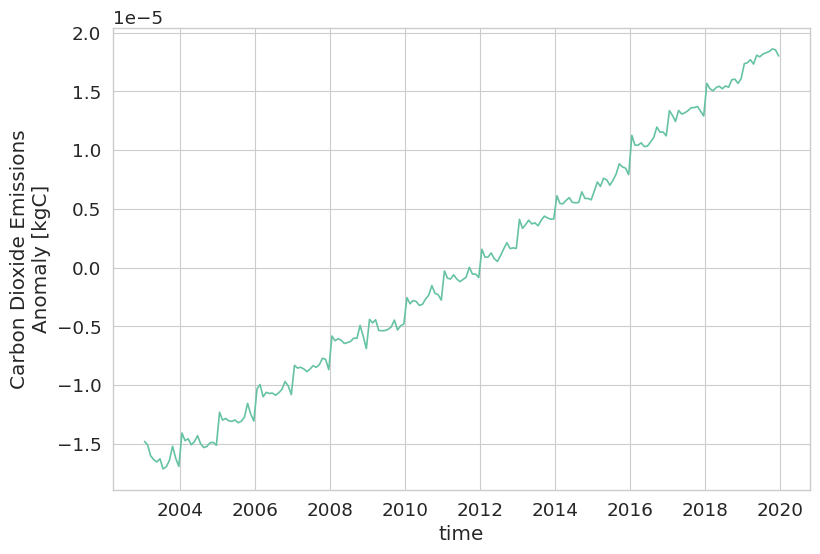

In [6]:
co2.mean(dim=["lat", "lon"], keep_attrs=True).plot()

<xarray.DataArray (vertex: 3804, vertex_other: 3804)> Size: 116MB
array([[ 0., nan, nan, ..., nan, nan, nan],
       [nan,  0., nan, ..., nan, nan, nan],
       [nan, nan,  0., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  0., nan, nan],
       [nan, nan, nan, ..., nan,  0., nan],
       [nan, nan, nan, ..., nan, nan,  0.]])
Coordinates:
  * vertex        (vertex) object 30kB MultiIndex
  * lat           (vertex) float64 30kB -55.0 -55.0 -53.0 ... 79.0 79.0 79.0
  * lon           (vertex) float64 30kB -69.0 -67.0 -73.0 ... 99.0 101.0 103.0
  * vertex_other  (vertex_other) object 30kB MultiIndex
  * lat_other     (vertex_other) float64 30kB -55.0 -55.0 -53.0 ... 79.0 79.0
  * lon_other     (vertex_other) float64 30kB -69.0 -67.0 -73.0 ... 101.0 103.0
Attributes:
    long_name:     Similarity matrix
    var_desc:      Similarity
    valid_range:   (0, 1)
    actual_range:  (0.0, 0.9998639549217652)

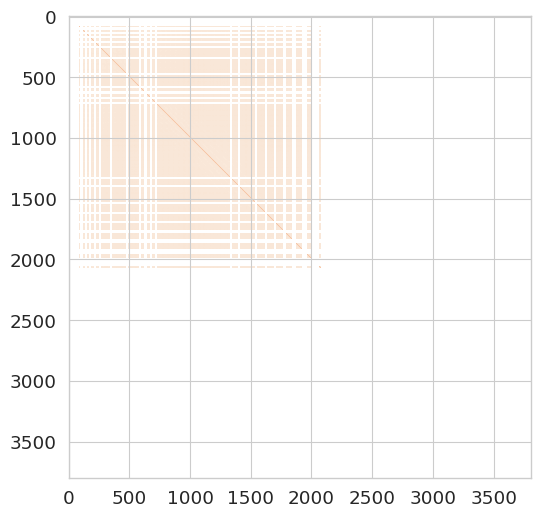

In [7]:
similarity_matrix = calc_similarity_matrix_v4(co2)
plt.imshow(similarity_matrix.values)
plt.draw()
similarity_matrix


(
    array([   3804.,       0.,       0.,       0.,       0.,       0.,
             0.,       0.,       0., 3506256.]),
    array([0.        , 0.0999864 , 0.19997279, 0.29995919, 0.39994558,
       0.49993198, 0.59991837, 0.69990477, 0.79989116, 0.89987756,
       0.99986395]),
    <BarContainer object of 10 artists>
)

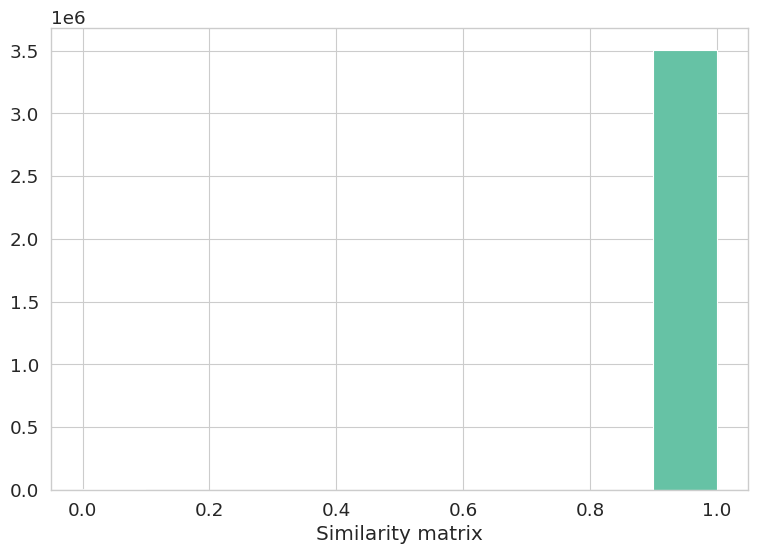

In [8]:
similarity_matrix.plot.hist()

Using a threshold of 0.9932737026627804 for the adjacency matrix

<xarray.DataArray (vertex: 3804, vertex_other: 3804)> Size: 116MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * vertex        (vertex) object 30kB MultiIndex
  * lat           (vertex) float64 30kB -55.0 -55.0 -53.0 ... 79.0 79.0 79.0
  * lon           (vertex) float64 30kB -69.0 -67.0 -73.0 ... 99.0 101.0 103.0
  * vertex_other  (vertex_other) object 30kB MultiIndex
  * lat_other     (vertex_other) float64 30kB -55.0 -55.0 -53.0 ... 79.0 79.0
  * lon_other     (vertex_other) float64 30kB -69.0 -67.0 -73.0 ... 101.0 103.0
Attributes:
    long_name:     Adjacency matrix
    var_desc:      Connected
    valid_range:   (0, 1)
    actual_range:  (0, 1)

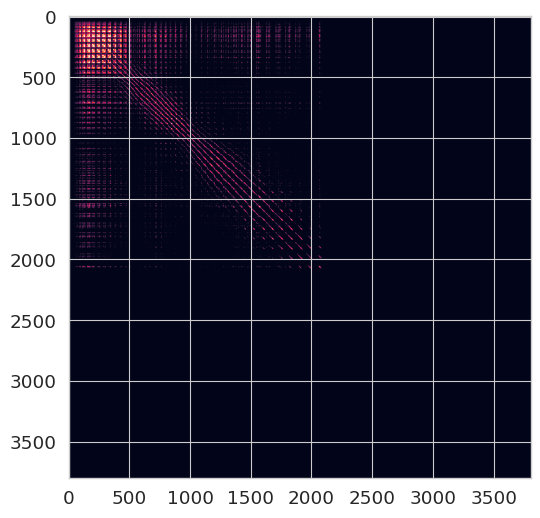

In [9]:
adjacency_matrix = calc_adjacency_matrix(similarity_matrix)
plt.imshow(adjacency_matrix.values)
plt.draw()
adjacency_matrix

<xarray.DataArray (lat: 90, lon: 180)> Size: 130kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
Attributes:
    long_name:     Connectivity of vertices
    var_desc:      Connectivity
    units:         °
    valid_range:   (0, inf)
    actual_range:  (0.0, 973.0)

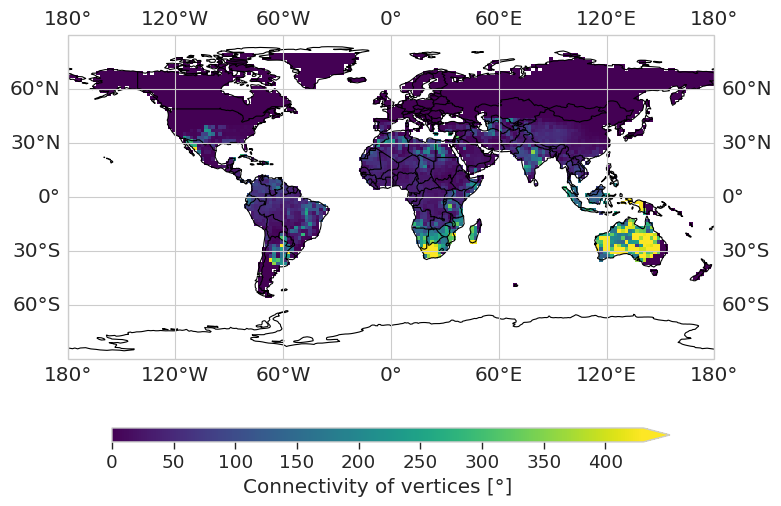

In [10]:
degrees = calc_degrees(adjacency_matrix, weighted=False).reindex_like(co2)
plot_world(degrees)
degrees

<xarray.DataArray (lat: 90, lon: 180)> Size: 130kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
Attributes:
    long_name:     Area-weighted connectivity of vertices
    var_desc:      Area-weighted connectivity
    valid_range:   (0, 1)
    actual_range:  (0.0, 16.04957362602255)

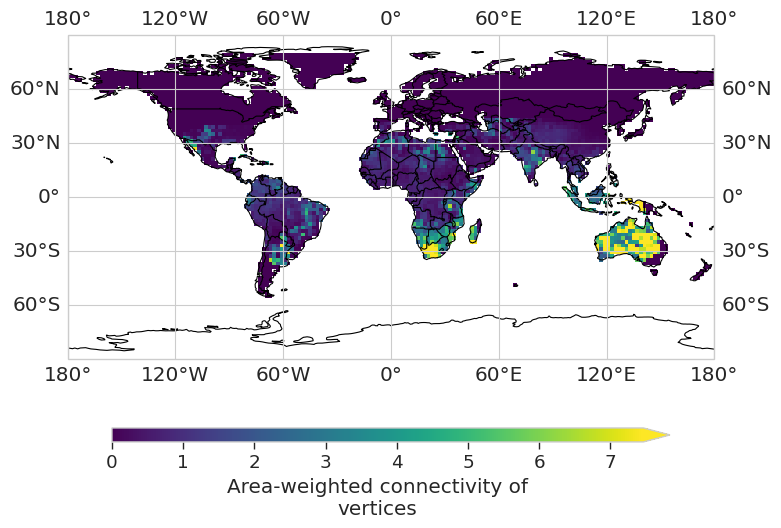

In [11]:
awc = calc_degrees(adjacency_matrix, weighted=True).reindex_like(co2)
plot_world(awc)
awc

<xarray.DataArray (vertex: 3804, vertex_other: 3804)> Size: 116MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * vertex        (vertex) object 30kB MultiIndex
  * lat           (vertex) float64 30kB -55.0 -55.0 -53.0 ... 79.0 79.0 79.0
  * lon           (vertex) float64 30kB -69.0 -67.0 -73.0 ... 99.0 101.0 103.0
  * vertex_other  (vertex_other) object 30kB MultiIndex
  * lat_other     (vertex_other) float64 30kB -55.0 -55.0 -53.0 ... 79.0 79.0
  * lon_other     (vertex_other) float64 30kB -69.0 -67.0 -73.0 ... 101.0 103.0
Attributes:
    long_name:     Link lengths of Adjacency matrix
    units:         km
    var_desc:      Link length
    valid_range:   (0, 20015.114442035923)
    actual_range:  (0.0, 19518.233369487243)

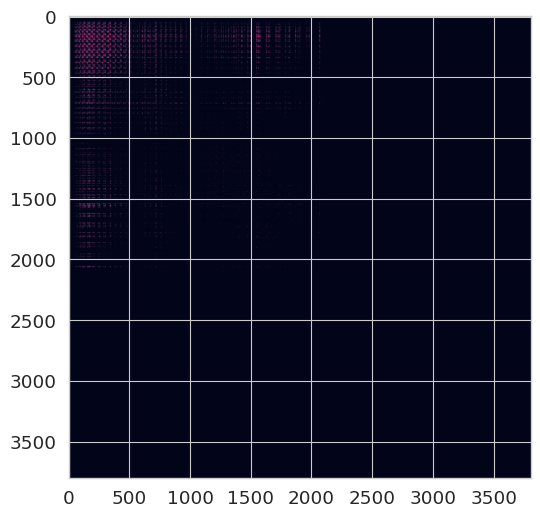

In [12]:
ll_adj_mtx = calc_link_length(adjacency_matrix)
plt.imshow(ll_adj_mtx.values)
plt.draw()
ll_adj_mtx

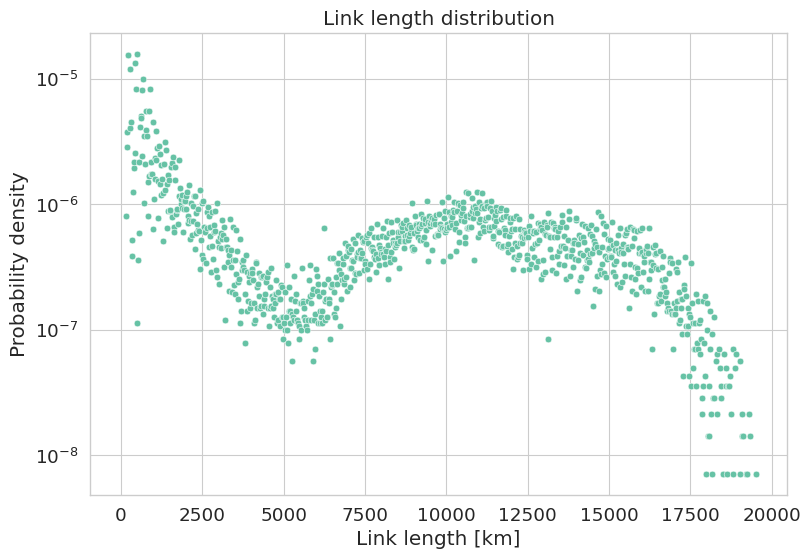

In [13]:
h, b = np.histogram(ll_adj_mtx.where(ll_adj_mtx > 0, 0), density=True, bins=1000)
ax = sns.scatterplot(x=b[1:-1], y=h[1:])
ax.set_yscale('log')
plt.title("Link length distribution")
plt.xlabel("Link length [km]")
plt.ylabel("Probability density")
plt.draw()

<xarray.DataArray (lat: 90, lon: 180)> Size: 130kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
Attributes:
    long_name:     Average link length of vertices
    var_desc:      Average link length
    units:         km
    valid_range:   (0, inf)
    actual_range:  (167.8363167977423, 13622.654761257478)

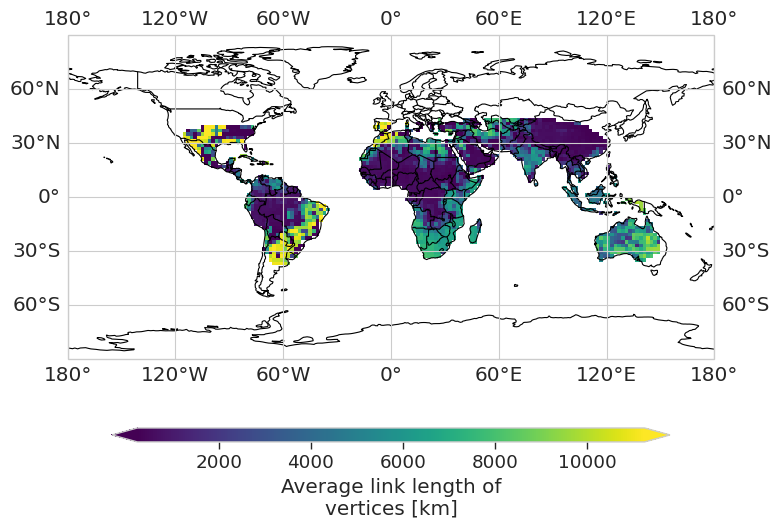

In [14]:
avg_ll = calc_avg_link_length(ll_adj_mtx).reindex_like(co2)
plot_world(avg_ll)
avg_ll

<xarray.DataArray (lat: 90, lon: 180)> Size: 130kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
Attributes:
    long_name:     Corrected Average link length of vertices
    var_desc:      Corrected Average link length
    units:         km
    valid_range:   (0, inf)
    actual_range:  (1.0623309049804481, 9302.370993682918)

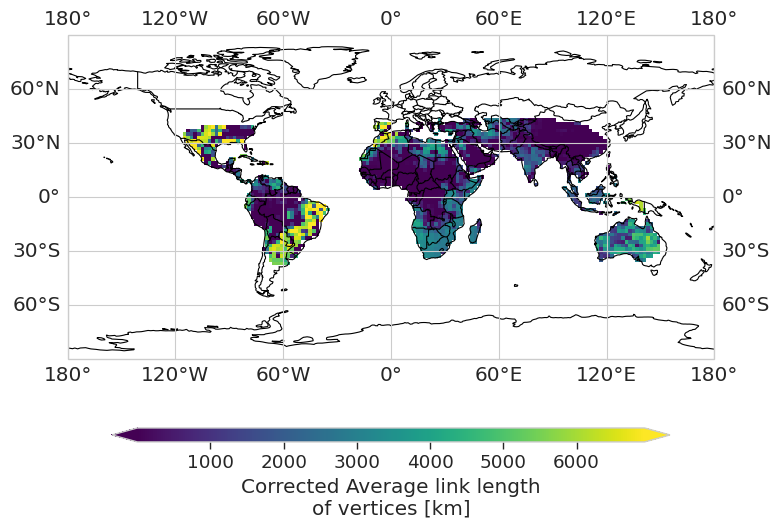

In [15]:
avg_ll = calc_avg_link_length(ll_adj_mtx, weighted=True).reindex_like(co2)
plot_world(avg_ll)
avg_ll